# CS 505 FINAL PROJECT

### Importing Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df = pd.read_csv('train.csv')
df

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
159995,Watch muhammad ali pull the greatest prank on ...,False
159996,Some days the problem is i care too much... to...,True
159997,If someone doesn't realize their blinker is st...,True
159998,I'm going out with a girl i met online who's a...,True


### Setting labels: True=1, False=0

In [3]:
df['humor'].unique()

array([False,  True])

In [4]:
df.dtypes

text     object
humor      bool
dtype: object

In [5]:
df['humor'] = df['humor'].astype(int)

In [6]:
df

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",0
1,Watch: darvish gave hitter whiplash with slow ...,0
2,What do you call a turtle without its shell? d...,1
3,5 reasons the 2016 election feels so personal,0
4,"Pasco police shot mexican migrant from behind,...",0
...,...,...
159995,Watch muhammad ali pull the greatest prank on ...,0
159996,Some days the problem is i care too much... to...,1
159997,If someone doesn't realize their blinker is st...,1
159998,I'm going out with a girl i met online who's a...,1


### Plot to see the distribution of humor and non-humor texts

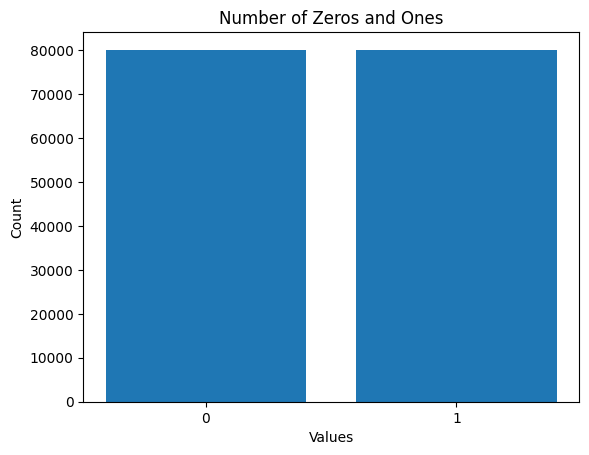

In [7]:
value_counts = df['humor'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.xticks([0, 1])
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Number of Zeros and Ones')
plt.show()

### Splitting Data into training, testing and validation sets

In [8]:
train_text, val_text, train_labels, val_labels = train_test_split(df['text'], df['humor'], test_size=0.1)

### Length Distribution

/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='text', ylabel='Count'>

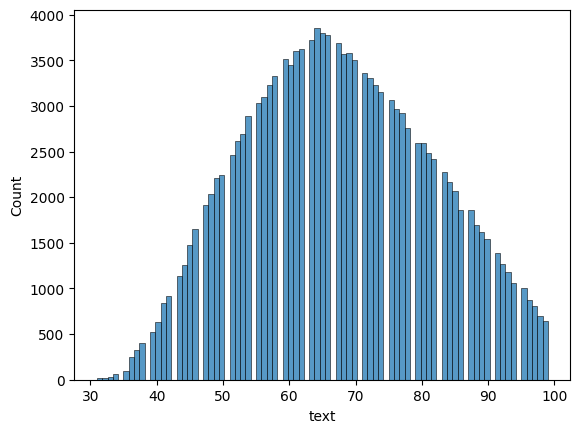

In [9]:
sns.histplot(train_text.apply(lambda x : len(x)))

### Import BERT

In [10]:

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


### Padding/ Truncating sequences

In [11]:
train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    padding='longest',
    truncation=True
)


val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    padding='longest',
    truncation=True
)

In [12]:
# test=tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     padding='longest',
#     truncation=True
# )

### Dataset and Data Loaders

In [13]:
train_seq = torch.tensor(train['input_ids'])
train_mask = torch.tensor(train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(val['input_ids'])
val_mask = torch.tensor(val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())



In [14]:
# test_seq = torch.tensor(test['input_ids'])
# test_mask = torch.tensor(test['attention_mask'])
# test_y = torch.tensor(test_labels.tolist())

In [15]:
batch_size = 64

train_ds = TensorDataset(train_seq, train_mask, train_y)
train_dataloader =   DataLoader(train_ds, batch_size = batch_size, shuffle = False)


val_ds = TensorDataset(val_seq, val_mask, val_y)
val_dataloader =  DataLoader(val_ds, batch_size = batch_size, shuffle = False)

In [16]:
# test_ds=TensorDataset(test_seq, test_mask, test_y)
# test_dataloader =   DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [17]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [20]:
from tqdm import tqdm
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_function = nn.CrossEntropyLoss()

def train(model, dataloader):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, total=len(dataloader)):
        batch = [r.to(device) for r in batch]
        inputs, masks, labels = batch
        model.zero_grad()

        outputs = model(inputs, attention_mask=masks)
        logits = outputs.logits
        loss = loss_function(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    return total_loss / len(dataloader)
    
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = [r.to(device) for r in batch]
            inputs, masks, labels = batch

            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
            loss = loss_function(logits, labels)
            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    average_loss = total_loss / len(dataloader)
    return average_loss, accuracy

epochs = 2

for epoch in range(epochs):
    train_loss = train(model, train_dataloader)
    val_loss, val_accuracy = evaluate(model, val_dataloader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
    

100%|██████████| 2250/2250 [06:48<00:00,  5.50it/s]


Epoch 1, Train Loss: 0.01263422039376423, Val Loss: 0.03861033862439217, Val Accuracy: 0.9884375


100%|██████████| 2250/2250 [06:49<00:00,  5.50it/s]


Epoch 2, Train Loss: 0.00643079150048935, Val Loss: 0.08834215437510283, Val Accuracy: 0.981625


In [21]:
MODEL_PATH = 'models/model1.pt'

torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
# def evaluate_accuracy(model, dataloader):
#     model.eval()
#     correct_predictions = 0
#     total_predictions = 0

#     with torch.no_grad():
#         for batch in dataloader:
#             batch = [r.to(device) for r in batch]
#             inputs, masks, labels = batch

#             outputs = model(inputs, attention_mask=masks)
#             logits = outputs.logits
#             predictions = torch.argmax(logits, dim=1)

#             correct_predictions += (predictions == labels).sum().item()
#             total_predictions += labels.size(0)

#     accuracy = correct_predictions / total_predictions
#     return accuracy

# # Calculate test accuracy
# test_accuracy = evaluate_accuracy(model, test_dataloader)
# print(f'Test Accuracy: {test_accuracy}')


# TESTING SCRIPT

In [22]:
test_df = pd.read_csv('dev.csv')
test_df['humor'] = test_df['humor'].astype(int)

test_text = test_df.text
test_labels = test_df['humor'].values

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

test=tokenizer.batch_encode_plus(
    test_text.tolist(),
    padding='longest',
    truncation=True
)

test_seq = torch.tensor(test['input_ids'])
test_mask = torch.tensor(test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

test_ds = TensorDataset(test_seq, test_mask, test_y)

test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=False)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [23]:
MODEL_PATH = 'models/model1.pt'

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [24]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = [r.to(device) for r in batch]
            inputs, masks, labels = batch

            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

# Calculate test accuracy
test_accuracy = evaluate_accuracy(model, test_dataloader)
print(f'Test Accuracy: {test_accuracy}')


Test Accuracy: 0.978025


In [25]:

def evaluate_model(model, dataloader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            batch = [r.to(device) for r in batch]
            inputs, masks, labels = batch

            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    accuracy = correct_predictions / total_predictions
    report = classification_report(all_labels, all_predictions, target_names=['Humor', 'Not'])  # replace YOUR_TARGET_NAMES with the list of class names
    return accuracy, report

# Calculate test accuracy and classification report
test_accuracy, test_report = evaluate_model(model, test_dataloader)
print(f'Test Accuracy: {test_accuracy}')
print(test_report)


Test Accuracy: 0.978025
              precision    recall  f1-score   support

       Humor       0.96      1.00      0.98     19918
         Not       1.00      0.96      0.98     20082

    accuracy                           0.98     40000
   macro avg       0.98      0.98      0.98     40000
weighted avg       0.98      0.98      0.98     40000



In [ ]:
#ELEKTRA 



# INFERENCE SCRIPT

In [26]:
test_df = pd.read_csv('test.csv')
test_text = test_df.text

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

test=tokenizer.batch_encode_plus(
    test_text.tolist(),
    padding='longest',
    truncation=True
)

test_seq = torch.tensor(test['input_ids'])
test_mask = torch.tensor(test['attention_mask'])

test_ds = TensorDataset(test_seq, test_mask)

test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=False)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [27]:
MODEL_PATH = 'models/model1.pt'

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [28]:

def return_predictions(model, dataloader):
    model.eval()
    
    predictions = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = [r.to(device) for r in batch]
            inputs, masks = batch
    
            outputs = model(inputs, attention_mask = masks)
            logits = outputs.logits
            predictions.extend([x.item() for x in torch.argmax(logits, dim=1)])
            
    return predictions


In [29]:
predictions = return_predictions(model, test_dataloader)

In [30]:
predictions = list(map(lambda x : True if x == 1 else False, predictions))
predictions[:5]

[True, True, True, True, False]

In [ ]:
################### THE END ################################

In [31]:
#### Getting Classification report for the above test file since the true labels for the same are present in the dev file

dev_df = pd.read_csv('dev.csv')

true_labels = dev_df['humor'].values

In [32]:
import numpy as np

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

       False       0.96      1.00      0.98     19918
        True       1.00      0.96      0.98     20082

    accuracy                           0.98     40000
   macro avg       0.98      0.98      0.98     40000
weighted avg       0.98      0.98      0.98     40000



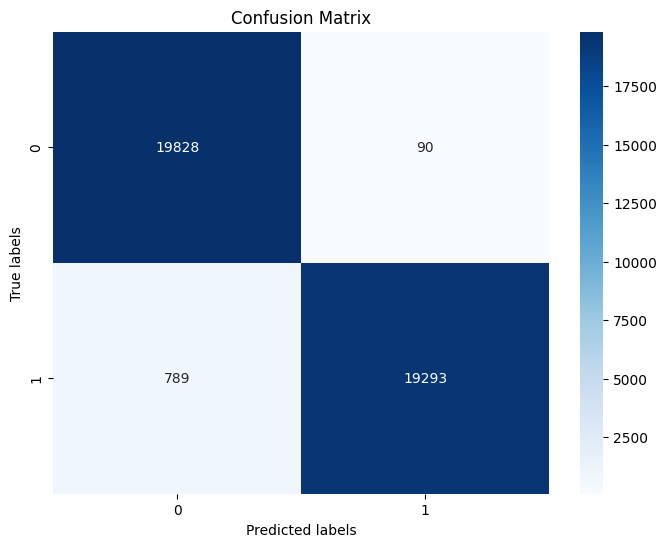

In [33]:
#Elektra 

# Add Confusion Matrix here
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
#Elektra 

# Detailed Analysis of Test Predictions
print("\nDetailed Analysis of Test Predictions:")

# Find indices where predictions are wrong
wrong_preds = np.where(predictions != true_labels)[0]

# Display some of these instances
for idx in wrong_preds[:10]:  # Adjust the number to display as needed
    print(f"Text: {test_df['text'].iloc[idx]}")
    print(f"True Label: {'Humor' if true_labels[idx] else 'Not Humor'}")
    print(f"Predicted: {'Humor' if predictions[idx] else 'Not Humor'}\n")



Detailed Analysis of Test Predictions:
Text: Do infants have as much fun in infancy as adults do in adultery?
True Label: Humor
Predicted: Not Humor

Text: Why didn't anyone believe the transsexual's confession? it was a case of 'he said, she said'
True Label: Humor
Predicted: Not Humor

Text: Met a hot isis girl jihad me at hello
True Label: Humor
Predicted: Not Humor

Text: The reality is men have no idea what women want... and women have no idea what women want
True Label: Humor
Predicted: Not Humor

Text: When your body is a solid 10 but your intro and conclusion need work
True Label: Humor
Predicted: Not Humor

Text: It's okay, little buddy. mommy cries when her bottle is empty, too.
True Label: Humor
Predicted: Not Humor

Text: Ariana grande looks like she was designed in a lab by japanese perverts
True Label: Humor
Predicted: Not Humor

Text: If you're happy and you know it, share your meds
True Label: Humor
Predicted: Not Humor

Text: Friends don't let friends make harlem shak

In [35]:
#Elektra - Sanity Checks 

# Sanity Check with specific examples
sanity_check_texts = [
    "I had a wonderful day at the office said no one ever.",
    "Great, another Monday.",
    "I’m not arguing, I’m just explaining why I’m right.",
    # Add more texts as needed
]

# Process these texts through the tokenizer
sanity_encoded = tokenizer.batch_encode_plus(
    sanity_check_texts,
    padding='longest',
    truncation=True,
    return_tensors='pt'
)

# Predicting humor in these texts
model.eval()
with torch.no_grad():
    outputs = model(sanity_encoded['input_ids'].to(device), attention_mask=sanity_encoded['attention_mask'].to(device))
    predictions = torch.argmax(outputs.logits, dim=1)

# Display the results
for text, pred in zip(sanity_check_texts, predictions):
    print(f"Text: '{text}'\nPredicted as Humorous: {'Yes' if pred.item() == 1 else 'No'}\n")


Text: 'I had a wonderful day at the office said no one ever.'
Predicted as Humorous: Yes

Text: 'Great, another Monday.'
Predicted as Humorous: Yes

Text: 'I’m not arguing, I’m just explaining why I’m right.'
Predicted as Humorous: No

